# Machine Learning with Random Forest on Wildfire Data
I'm going to continue working with the wildfire data that I explored with ggplot. This notebook will look at using the machine learning tool Random Forest.


## Import Libraries
The first step includes importing various libraries that will be used for the data set.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

## Random Forest Explained
"Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set."

For those who would like more in depth information on random forest check out the links below.

https://en.wikipedia.org/wiki/Random_forest

https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d

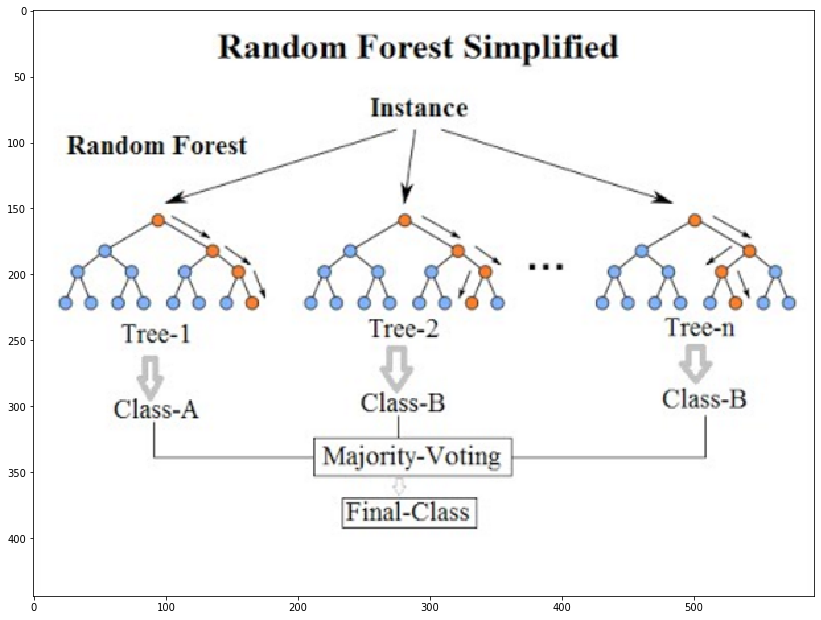

In [2]:
from PIL import Image 
import requests
#how to load an url image in python
response = requests.get('https://miro.medium.com/max/592/1*i0o8mjFfCn-uD79-F1Cqkw.png', stream=True)
img = Image.open(response.raw)
plt.figure(figsize = (14,12))
plt.imshow(img)
plt.show()

## Load in the data
Load in the data from the sqlite database. Again the focus will be on large wildfires which is 1000+ acres or more burned. I will focus on the latitude, longitude, date,and cause.

In [3]:
conn = sqlite3.connect('C:/Users/blong/Desktop/Python/188-million-us-wildfires/FPA_FOD_20170508.sqlite')

In [4]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE, FIRE_SIZE_CLASS FROM 'Fires' WHERE FIRE_SIZE_CLASS ='G' OR FIRE_SIZE_CLASS ='F' ", conn)

In [5]:
df.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS
0,2004,Equipment Use,38.523333,-120.211667,CA,2453284.5,16823.0,G
1,2004,Equipment Use,38.780000,-120.260000,CA,2453291.5,7700.0,G
2,2005,Lightning,33.723333,-111.275000,AZ,2453542.5,16100.0,G
3,2005,Miscellaneous,35.688056,-118.438333,CA,2453560.5,1149.0,F
4,2005,Lightning,33.933611,-111.379722,AZ,2453567.5,1300.0,F


## Change date
DISCOVERY_DATE variable is in the Julian Date format. I want to convert this variable to Gregorian dates, the date format which is used everyday. I can then use the Gregorian date to get some additional data variable which are month and day of the week.

In [6]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
print(df['DATE'].head())

0   1970-01-01 00:00:00.002453284
1   1970-01-01 00:00:00.002453291
2   1970-01-01 00:00:00.002453542
3   1970-01-01 00:00:00.002453560
4   1970-01-01 00:00:00.002453567
Name: DATE, dtype: datetime64[ns]


In [7]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.weekday_name
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2004    Equipment Use  38.523333 -120.211667    CA       2453284.5   
1       2004    Equipment Use  38.780000 -120.260000    CA       2453291.5   
2       2005        Lightning  33.723333 -111.275000    AZ       2453542.5   
3       2005    Miscellaneous  35.688056 -118.438333    CA       2453560.5   
4       2005        Lightning  33.933611 -111.379722    AZ       2453567.5   

   FIRE_SIZE FIRE_SIZE_CLASS                          DATE  MONTH DAY_OF_WEEK  
0    16823.0               G 1970-01-01 00:00:00.002453284      1    Thursday  
1     7700.0               G 1970-01-01 00:00:00.002453291      1    Thursday  
2    16100.0               G 1970-01-01 00:00:00.002453542      1    Thursday  
3     1149.0               F 1970-01-01 00:00:00.002453560      1    Thursday  
4     1300.0               F 1970-01-01 00:00:00.002453567      1    Thursday  


## Transform Data
Convert all features to numeric values, this is necessary for the machine learning stage.

In [8]:
df_CA = df[df['STATE']=='CA']
df_FL = df[df['STATE']=='FL']

In [9]:
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['FIRE_SIZE_CLASS'] = le.fit_transform(df['FIRE_SIZE_CLASS'])
print(df.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2004                 4  38.523333 -120.211667      4       2453284.5   
1       2004                 4  38.780000 -120.260000      4       2453291.5   
2       2005                 6  33.723333 -111.275000      3       2453542.5   
3       2005                 7  35.688056 -118.438333      4       2453560.5   
4       2005                 6  33.933611 -111.379722      3       2453567.5   

   FIRE_SIZE  FIRE_SIZE_CLASS                          DATE  MONTH  \
0    16823.0                1 1970-01-01 00:00:00.002453284      1   
1     7700.0                1 1970-01-01 00:00:00.002453291      1   
2    16100.0                1 1970-01-01 00:00:00.002453542      1   
3     1149.0                0 1970-01-01 00:00:00.002453560      1   
4     1300.0                0 1970-01-01 00:00:00.002453567      1   

   DAY_OF_WEEK  
0            0  
1            0  
2            0  
3            0  
4            

## Heatmap
A heatmap can be made to see the correlations more visually.

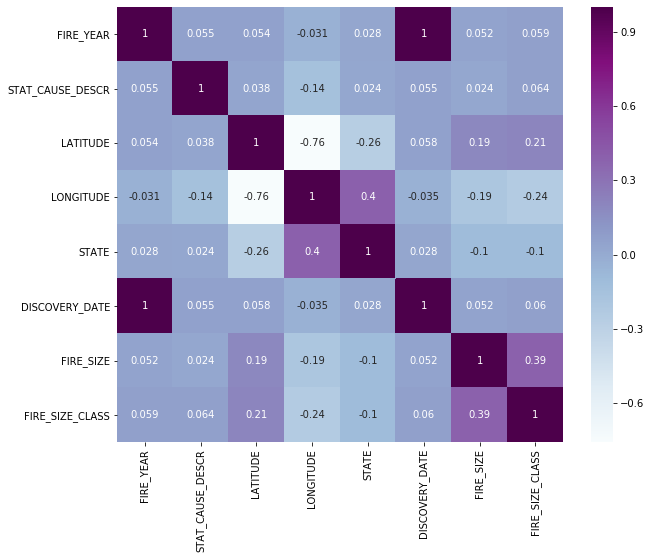

In [10]:
df_corr=df
df_corr = df_corr.drop('MONTH',axis=1)
df_corr = df_corr.drop('DAY_OF_WEEK',axis=1)

plt.figure(figsize = (10,8))

corr = df_corr.corr()
sns.heatmap(corr, cmap='BuPu', annot=True)

There is not much strong correlation between the variables. Besides the more obvious such as date which has the year in it and fire size and fire size class. The most interesting correlation seems to be fire size and latitude which mostly likely correlates to weather.

## Count plots for California and Florida

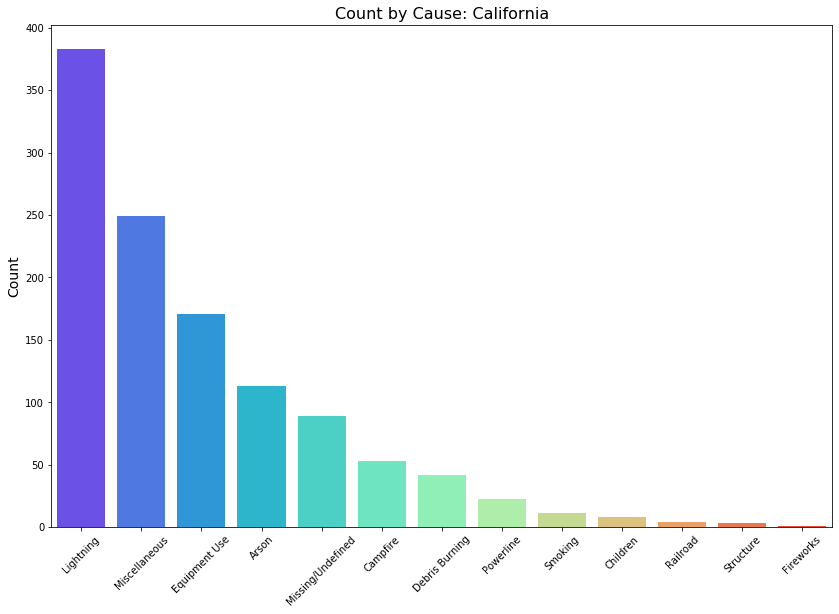

In [11]:
plt.figure(figsize = (14,9))

g = sns.countplot('STAT_CAUSE_DESCR',order=df_CA['STAT_CAUSE_DESCR'].value_counts().index, data=df_CA, palette="rainbow")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Count by Cause: California", fontsize=16)
g.set_xlabel("", fontsize=14)
g.set_ylabel("Count", fontsize=14)
plt.subplots_adjust(hspace = 0.9, top = 0.9)

There are 13 different causes of large fires in California with the most common being Lightning, Misc, Equipment Use and Arson,

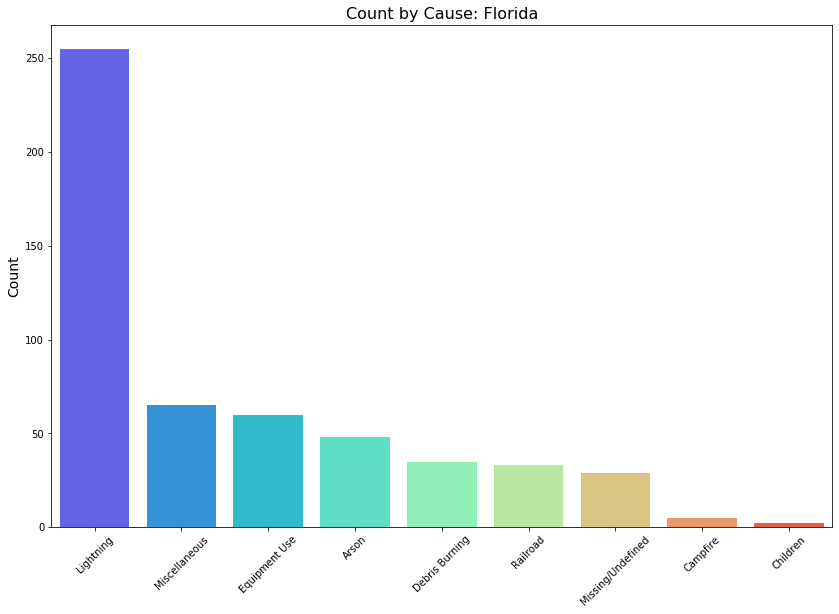

In [12]:
plt.figure(figsize = (14,9))

g = sns.countplot('STAT_CAUSE_DESCR',order=df_FL['STAT_CAUSE_DESCR'].value_counts().index, data=df_FL, palette="rainbow")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Count by Cause: Florida", fontsize=16)
g.set_xlabel("", fontsize=14)
g.set_ylabel("Count", fontsize=14)
plt.subplots_adjust(hspace = 0.9, top = 0.9)

There are 9 different causes of large fires in Florida. The most common being Lightning, Misc, Equipment Use, and Arson

# Random Forest 
The first Random Forest process goal is to predict the cause of the fire = STAT_CAUSE_DESCR. Using supervised learning a training and test dataset need to be created.

In [13]:
df = df.drop('DATE',axis=1)
df = df.dropna()
print(df.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2004                 4  38.523333 -120.211667      4       2453284.5   
1       2004                 4  38.780000 -120.260000      4       2453291.5   
2       2005                 6  33.723333 -111.275000      3       2453542.5   
3       2005                 7  35.688056 -118.438333      4       2453560.5   
4       2005                 6  33.933611 -111.379722      3       2453567.5   

   FIRE_SIZE  FIRE_SIZE_CLASS  MONTH  DAY_OF_WEEK  
0    16823.0                1      1            0  
1     7700.0                1      1            0  
2    16100.0                1      1            0  
3     1149.0                0      1            0  
4     1300.0                0      1            0  


In [14]:
X = df.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = df['STAT_CAUSE_DESCR'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) #30% for testing, 70% for training, random state 42 because it's answer of the universe

In [16]:
clf_rf = ske.RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.6133217993079585


61.3% accuracy in predicting the cause of the first. This is not terrible, better than I expected. I am going to see if I can improve those results by making the algorithm have less classes.

## Random Forest on California and Florida
Next I will focus on California and Florida. I want to see if Random Forest can predict the causes of certain fires. I am going to look into more man made fires causes. Also I am going to drop a lot of the variables that are known after the fire. I want to see if we can predict the cause of fire by just the Latitude, Longitude, Month, year, and day of week! Which is known since the very beginning. For each Random Forest a cause will be set to 0 or 1 then certain classes will be dropped. The remaining classes will be run through the Random Forest Machine Learning Algorithm.

In [17]:
#Creat a copy of the data frames for the different Random Forets
df2_CA = df_CA
df2_FL = df_FL

In [18]:
def set_equipment_use_label(cause):
    equipment_use = 0
    if cause == 'Equipment Use':
        equipment_use = 1
    return equipment_use
     

df_CA['EQUIPMENT_USE'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_equipment_use_label(x)) 
print(df_CA.head())

    FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0        2004    Equipment Use  38.523333 -120.211667    CA       2453284.5   
1        2004    Equipment Use  38.780000 -120.260000    CA       2453291.5   
3        2005    Miscellaneous  35.688056 -118.438333    CA       2453560.5   
26       2005    Miscellaneous  39.612222 -120.351667    CA       2453606.5   
40       2005    Miscellaneous  41.499722 -123.276389    CA       2453634.5   

    FIRE_SIZE FIRE_SIZE_CLASS                          DATE  MONTH  \
0     16823.0               G 1970-01-01 00:00:00.002453284      1   
1      7700.0               G 1970-01-01 00:00:00.002453291      1   
3      1149.0               F 1970-01-01 00:00:00.002453560      1   
26     2270.0               F 1970-01-01 00:00:00.002453606      1   
40     3225.0               F 1970-01-01 00:00:00.002453634      1   

   DAY_OF_WEEK  EQUIPMENT_USE  
0     Thursday              1  
1     Thursday              1  
3     Th

In [19]:
df_CA = df_CA.drop('DATE',axis=1)
df_CA = df_CA.drop('STATE',axis=1)
df_CA = df_CA.drop('STAT_CAUSE_DESCR',axis=1)
df_CA = df_CA.drop('FIRE_SIZE',axis=1)
df_CA = df_CA.drop('FIRE_SIZE_CLASS',axis=1)
df_CA = df_CA.drop('DISCOVERY_DATE',axis=1)
df_CA = df_CA.dropna()

le = preprocessing.LabelEncoder()
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])

print(df_CA.head())

    FIRE_YEAR   LATITUDE   LONGITUDE  MONTH  DAY_OF_WEEK  EQUIPMENT_USE
0        2004  38.523333 -120.211667      1            0              1
1        2004  38.780000 -120.260000      1            0              1
3        2005  35.688056 -118.438333      1            0              0
26       2005  39.612222 -120.351667      1            0              0
40       2005  41.499722 -123.276389      1            0              0


In [20]:
X = df_CA.drop(['EQUIPMENT_USE'], axis=1).values
y = df_CA['EQUIPMENT_USE'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) 
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.8202898550724638


The Random Forest was able to predict with 82.0% accuary with less classes this is a major imporvement over the very frist Random Forest.

In [21]:
def set_campfire_label(cause):
    campfire = 0
    if cause == 'Campfire':
        campfire = 1
    return campfire
     

df2_CA['CAMPFIRE'] = df2_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_campfire_label(x)) 
print(df2_CA.head())

    FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0        2004    Equipment Use  38.523333 -120.211667    CA       2453284.5   
1        2004    Equipment Use  38.780000 -120.260000    CA       2453291.5   
3        2005    Miscellaneous  35.688056 -118.438333    CA       2453560.5   
26       2005    Miscellaneous  39.612222 -120.351667    CA       2453606.5   
40       2005    Miscellaneous  41.499722 -123.276389    CA       2453634.5   

    FIRE_SIZE FIRE_SIZE_CLASS                          DATE  MONTH  \
0     16823.0               G 1970-01-01 00:00:00.002453284      1   
1      7700.0               G 1970-01-01 00:00:00.002453291      1   
3      1149.0               F 1970-01-01 00:00:00.002453560      1   
26     2270.0               F 1970-01-01 00:00:00.002453606      1   
40     3225.0               F 1970-01-01 00:00:00.002453634      1   

   DAY_OF_WEEK  EQUIPMENT_USE  CAMPFIRE  
0     Thursday              1         0  
1     Thursday      

In [22]:
df2_CA = df2_CA.drop('DATE',axis=1)
df2_CA = df2_CA.drop('STATE',axis=1)
df2_CA = df2_CA.drop('STAT_CAUSE_DESCR',axis=1)
df2_CA = df2_CA.drop('FIRE_SIZE',axis=1)
df2_CA = df2_CA.drop('FIRE_SIZE_CLASS',axis=1)
df2_CA = df2_CA.drop('DISCOVERY_DATE',axis=1)
df2_CA = df2_CA.drop('EQUIPMENT_USE',axis=1)
df2_CA = df2_CA.dropna()

le = preprocessing.LabelEncoder()
df2_CA['DAY_OF_WEEK'] = le.fit_transform(df2_CA['DAY_OF_WEEK'])

print(df2_CA.head())

    FIRE_YEAR   LATITUDE   LONGITUDE  MONTH  DAY_OF_WEEK  CAMPFIRE
0        2004  38.523333 -120.211667      1            0         0
1        2004  38.780000 -120.260000      1            0         0
3        2005  35.688056 -118.438333      1            0         0
26       2005  39.612222 -120.351667      1            0         0
40       2005  41.499722 -123.276389      1            0         0


In [23]:
X = df2_CA.drop(['CAMPFIRE'], axis=1).values
y = df2_CA['CAMPFIRE'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.9478260869565217


Wow for campfire the algorithm predicted 94.7% accuracy mostly due the latitude and longitude since camps will be in the same locations and people camp in the summer more often so those months will help train the algorithm.

## Random Forest: Florida

In [24]:
def set_debris_burning_label(cause):
    debris_burning = 0
    if cause == 'Debris Burning':
        debris_burning = 1
    return debris_burning
     

df_FL['DEBRIS_BURNING'] = df_FL['STAT_CAUSE_DESCR'].apply(lambda x: set_debris_burning_label(x)) 
print(df_FL.head())

     FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE  LONGITUDE STATE  DISCOVERY_DATE  \
60        2005            Arson  30.216667 -84.983333    FL       2453666.5   
107       2006        Lightning  30.362222 -82.386944    FL       2453883.5   
227       2006        Lightning  30.135833 -84.968889    FL       2453917.5   
228       2006    Miscellaneous  29.216667 -81.697222    FL       2453958.5   
400       2007        Lightning  30.500000 -82.366667    FL       2454228.5   

     FIRE_SIZE FIRE_SIZE_CLASS                          DATE  MONTH  \
60     4384.92               F 1970-01-01 00:00:00.002453666      1   
107    3259.00               F 1970-01-01 00:00:00.002453883      1   
227    1073.00               F 1970-01-01 00:00:00.002453917      1   
228    4014.00               F 1970-01-01 00:00:00.002453958      1   
400  123014.00               G 1970-01-01 00:00:00.002454228      1   

    DAY_OF_WEEK  DEBRIS_BURNING  
60     Thursday               0  
107    Thursday               

In [25]:
df_FL = df_FL.drop('DATE',axis=1)
df_FL = df_FL.drop('STATE',axis=1)
df_FL = df_FL.drop('STAT_CAUSE_DESCR',axis=1)
df_FL = df_FL.drop('FIRE_SIZE_CLASS',axis=1)
df_FL = df_FL.drop('FIRE_SIZE',axis=1)
df_FL = df_FL.drop('DISCOVERY_DATE',axis=1)
df_FL = df_FL.dropna()


le = preprocessing.LabelEncoder()
df_FL['DAY_OF_WEEK'] = le.fit_transform(df_FL['DAY_OF_WEEK'])

print(df_FL.head())

     FIRE_YEAR   LATITUDE  LONGITUDE  MONTH  DAY_OF_WEEK  DEBRIS_BURNING
60        2005  30.216667 -84.983333      1            0               0
107       2006  30.362222 -82.386944      1            0               0
227       2006  30.135833 -84.968889      1            0               0
228       2006  29.216667 -81.697222      1            0               0
400       2007  30.500000 -82.366667      1            0               0


In [26]:
X = df_FL.drop(['DEBRIS_BURNING'], axis=1).values
y = df_FL['DEBRIS_BURNING'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) 
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.9


For debris that is burning the Random Forest predicts a 90.0% accuracy.

In [27]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df2_FL['ARSON'] = df2_FL['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
print(df2_FL.head())

     FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE  LONGITUDE STATE  DISCOVERY_DATE  \
60        2005            Arson  30.216667 -84.983333    FL       2453666.5   
107       2006        Lightning  30.362222 -82.386944    FL       2453883.5   
227       2006        Lightning  30.135833 -84.968889    FL       2453917.5   
228       2006    Miscellaneous  29.216667 -81.697222    FL       2453958.5   
400       2007        Lightning  30.500000 -82.366667    FL       2454228.5   

     FIRE_SIZE FIRE_SIZE_CLASS                          DATE  MONTH  \
60     4384.92               F 1970-01-01 00:00:00.002453666      1   
107    3259.00               F 1970-01-01 00:00:00.002453883      1   
227    1073.00               F 1970-01-01 00:00:00.002453917      1   
228    4014.00               F 1970-01-01 00:00:00.002453958      1   
400  123014.00               G 1970-01-01 00:00:00.002454228      1   

    DAY_OF_WEEK  DEBRIS_BURNING  ARSON  
60     Thursday               0      1  
107    Thursday 

In [28]:
df2_FL = df2_FL.drop('DATE',axis=1)
df2_FL = df2_FL.drop('STATE',axis=1)
df2_FL = df2_FL.drop('STAT_CAUSE_DESCR',axis=1)
df2_FL = df2_FL.drop('FIRE_SIZE_CLASS',axis=1)
df2_FL = df2_FL.drop('FIRE_SIZE',axis=1)
df2_FL = df2_FL.drop('DISCOVERY_DATE',axis=1)
df2_FL = df2_FL.drop('DEBRIS_BURNING',axis=1)
df2_FL = df2_FL.dropna()


le = preprocessing.LabelEncoder()
df2_FL['DAY_OF_WEEK'] = le.fit_transform(df2_FL['DAY_OF_WEEK'])

print(df2_FL.head())

     FIRE_YEAR   LATITUDE  LONGITUDE  MONTH  DAY_OF_WEEK  ARSON
60        2005  30.216667 -84.983333      1            0      1
107       2006  30.362222 -82.386944      1            0      0
227       2006  30.135833 -84.968889      1            0      0
228       2006  29.216667 -81.697222      1            0      0
400       2007  30.500000 -82.366667      1            0      0


In [29]:
X = df2_FL.drop(['ARSON'], axis=1).values
y = df2_FL['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) 
clf_rf = ske.RandomForestClassifier(n_estimators=200)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.9


Random Forest for Aarson is able to achieve a 90.0% accuracy.

## Conclusion
Here are 5 examples of Random Forest machine learning. It performed pretty well in predicitng in the class of the cause with data that was only aviable at the start of the fire. This show the power of Random Forest a very useful supervised learning machine learning tool.